In [1]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, Layout
from IPython.display import display, HTML

# --- Configuration ---
FINAL_RANKING_JSON = "final_quality_ranking.json"
DATASET_JSON = "dataset_qwen_pe_test.json"
BASE_DIR = "pico-banana-400k-subject_driven/openimages"

# 1. Load Ranking Data
if not os.path.exists(FINAL_RANKING_JSON):
    print(f"Error: {FINAL_RANKING_JSON} not found. Please run combine_and_rank.py first.")
    ranking_data = []
    final_scores = []
else:
    with open(FINAL_RANKING_JSON, 'r') as f:
        ranking_data = json.load(f)
    
    # Ensure sorted by Final Score (Desc)
    ranking_data.sort(key=lambda x: x["final_score"], reverse=True)
    final_scores = [x["final_score"] for x in ranking_data]
    print(f"Loaded {len(ranking_data)} ranked samples.")

# 2. Load Full Dataset (ONCE, outside the loop for speed)
if os.path.exists(DATASET_JSON):
    with open(DATASET_JSON, 'r') as f:
        full_dataset = json.load(f)
    print(f"Loaded full dataset with {len(full_dataset)} entries.")
else:
    full_dataset = []



Loaded 1444 ranked samples.
Loaded full dataset with 1444 entries.


In [2]:
# --- Advanced Interactive Viewer (Split-Source Visualization) ---

def view_sample(rank_idx, show_crop):
    if not ranking_data or rank_idx >= len(ranking_data): return
    
    entry = ranking_data[rank_idx]
    idx = entry["index"]
    final_s = entry["final_score"]
    
    if idx >= len(full_dataset): return
    item = full_dataset[idx]
    
    path_edit = os.path.join(BASE_DIR, item["edit_image"][0] if isinstance(item["edit_image"], list) else item["edit_image"])
    path_target = os.path.join(BASE_DIR, item["image"])
    path_mask = os.path.join(BASE_DIR, item["back_mask"])
    
    if not os.path.exists(path_edit): return print(f"Missing: {path_edit}")
    
    img_edit = cv2.imread(path_edit)
    img_target = cv2.imread(path_target)
    img_mask = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)
    
    if img_edit is None or img_target is None or img_mask is None: return
    
    # Resize logic (Sync sizes)
    h, w = img_target.shape[:2]
    if img_edit.shape[:2] != (h, w): img_edit = cv2.resize(img_edit, (w, h))
    if img_mask.shape != (h, w): img_mask = cv2.resize(img_mask, (w, h), interpolation=cv2.INTER_NEAREST)
        
    # --- Calculate Visualizations ---
    # 1. Ghosting Heatmap
    diff_map = np.abs(img_edit.astype(float) - img_target.astype(float)).mean(axis=2)
    kernel_bg = np.ones((9, 9), np.uint8)
    dilated_mask = cv2.dilate(img_mask, kernel_bg, iterations=8)
    bg_ring = cv2.subtract(dilated_mask, img_mask).astype(float) / 255.0
    ghost_vis = np.clip(diff_map * bg_ring * 3, 0, 255).astype(np.uint8)
    ghost_heatmap = cv2.applyColorMap(ghost_vis, cv2.COLORMAP_JET)
    
    # 2. Hard Cut Heatmap
    gray_edit = cv2.cvtColor(img_edit, cv2.COLOR_BGR2GRAY)
    gx = cv2.Sobel(gray_edit, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray_edit, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = cv2.magnitude(gx, gy)
    kernel_edge = np.ones((3, 3), np.uint8)
    boundary = cv2.subtract(cv2.dilate(img_mask, kernel_edge), cv2.erode(img_mask, kernel_edge)).astype(float) / 255.0
    cut_vis = np.clip(grad_mag * boundary * 2, 0, 255).astype(np.uint8)
    cut_heatmap = cv2.applyColorMap(cut_vis, cv2.COLORMAP_HOT)
    
    # Crop Logic
    y_min, y_max, x_min, x_max = 0, h, 0, w
    if show_crop:
        ys, xs = np.where(dilated_mask > 0)
        if len(ys) > 0:
            pad = 60
            y_min, y_max = max(0, np.min(ys)-pad), min(h, np.max(ys)+pad)
            x_min, x_max = max(0, np.min(xs)-pad), min(w, np.max(xs)+pad)

    def crop(img): return img[y_min:y_max, x_min:x_max]

    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes[0,0].imshow(cv2.cvtColor(crop(img_edit), cv2.COLOR_BGR2RGB)); axes[0,0].set_title("Edit"); axes[0,0].axis('off')
    axes[0,1].imshow(cv2.cvtColor(crop(img_target), cv2.COLOR_BGR2RGB)); axes[0,1].set_title("Target"); axes[0,1].axis('off')
    axes[1,0].imshow(cv2.cvtColor(crop(ghost_heatmap), cv2.COLOR_BGR2RGB)); axes[1,0].set_title("Ghosting"); axes[1,0].axis('off')
    axes[1,1].imshow(cv2.cvtColor(crop(cut_heatmap), cv2.COLOR_BGR2RGB)); axes[1,1].set_title("Hard Cut"); axes[1,1].axis('off')
    plt.suptitle(f"Rank #{rank_idx} | Score: {final_s:.2f}", fontsize=16)
    plt.tight_layout(); plt.show()

interact(view_sample, 
         rank_idx=IntSlider(min=0, max=max(0, len(ranking_data)-1), step=1, value=0, description='Ranking', layout=Layout(width='90%')),
         show_crop=Checkbox(value=True, description='Zoom'));



interactive(children=(IntSlider(value=0, description='Ranking', layout=Layout(width='90%'), max=1443), Checkbo…

Generating Top 10 WORST samples (Highest Ghosting/Cut Score)...


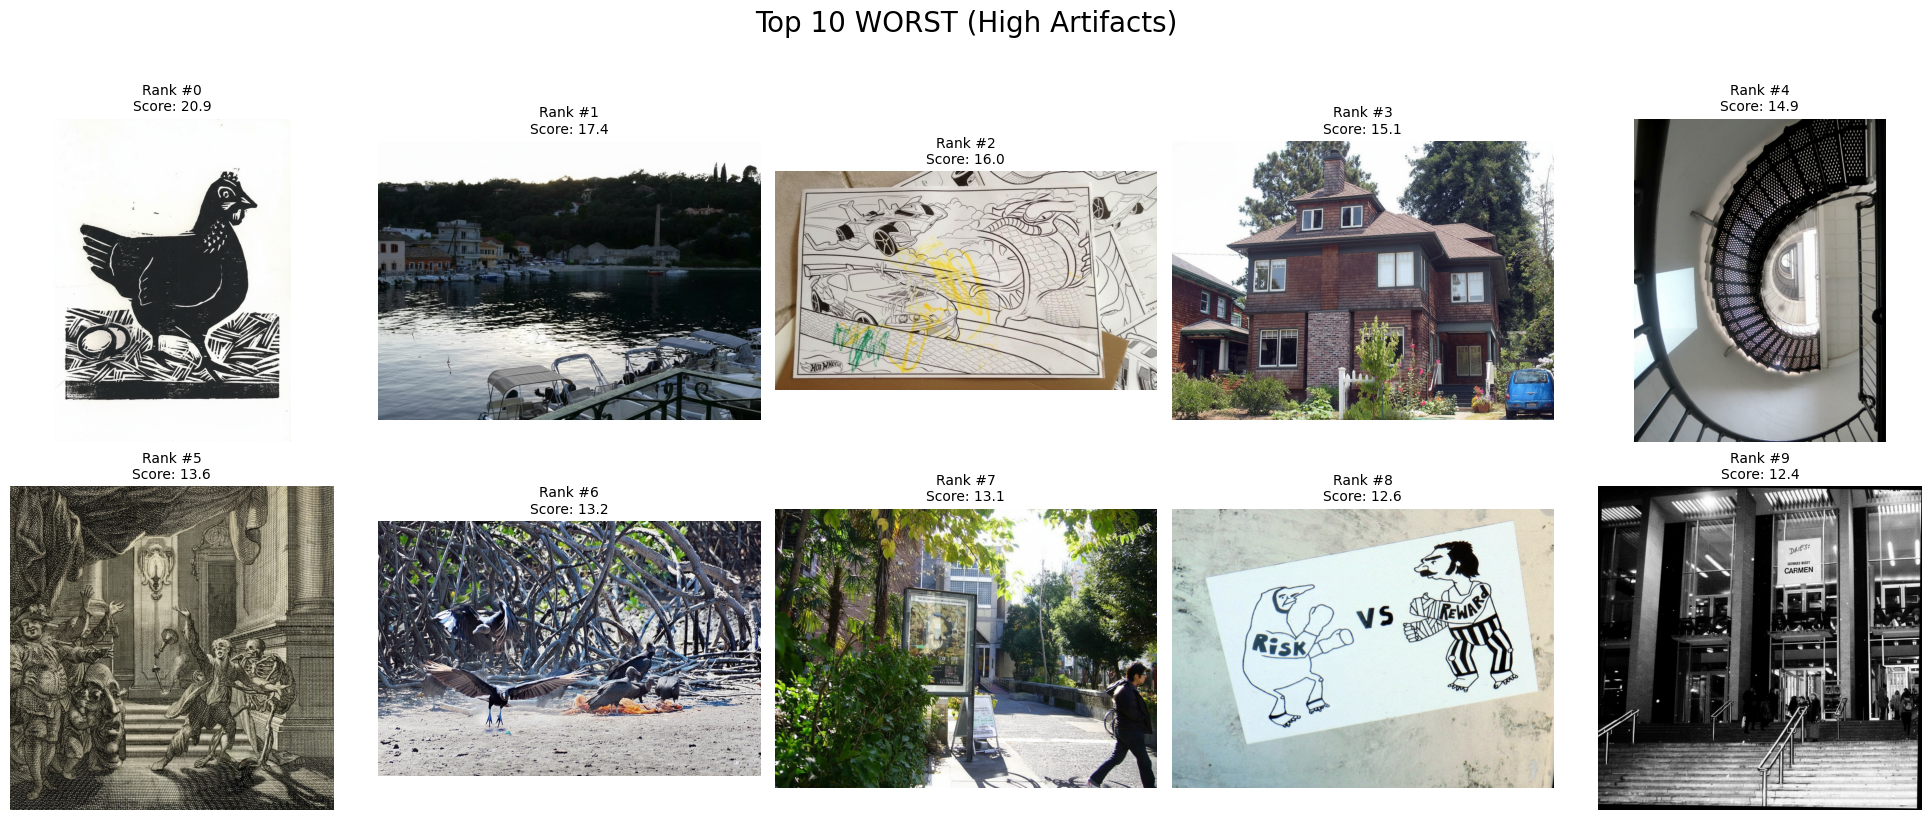

Generating Top 10 BEST samples (Lowest Score)...


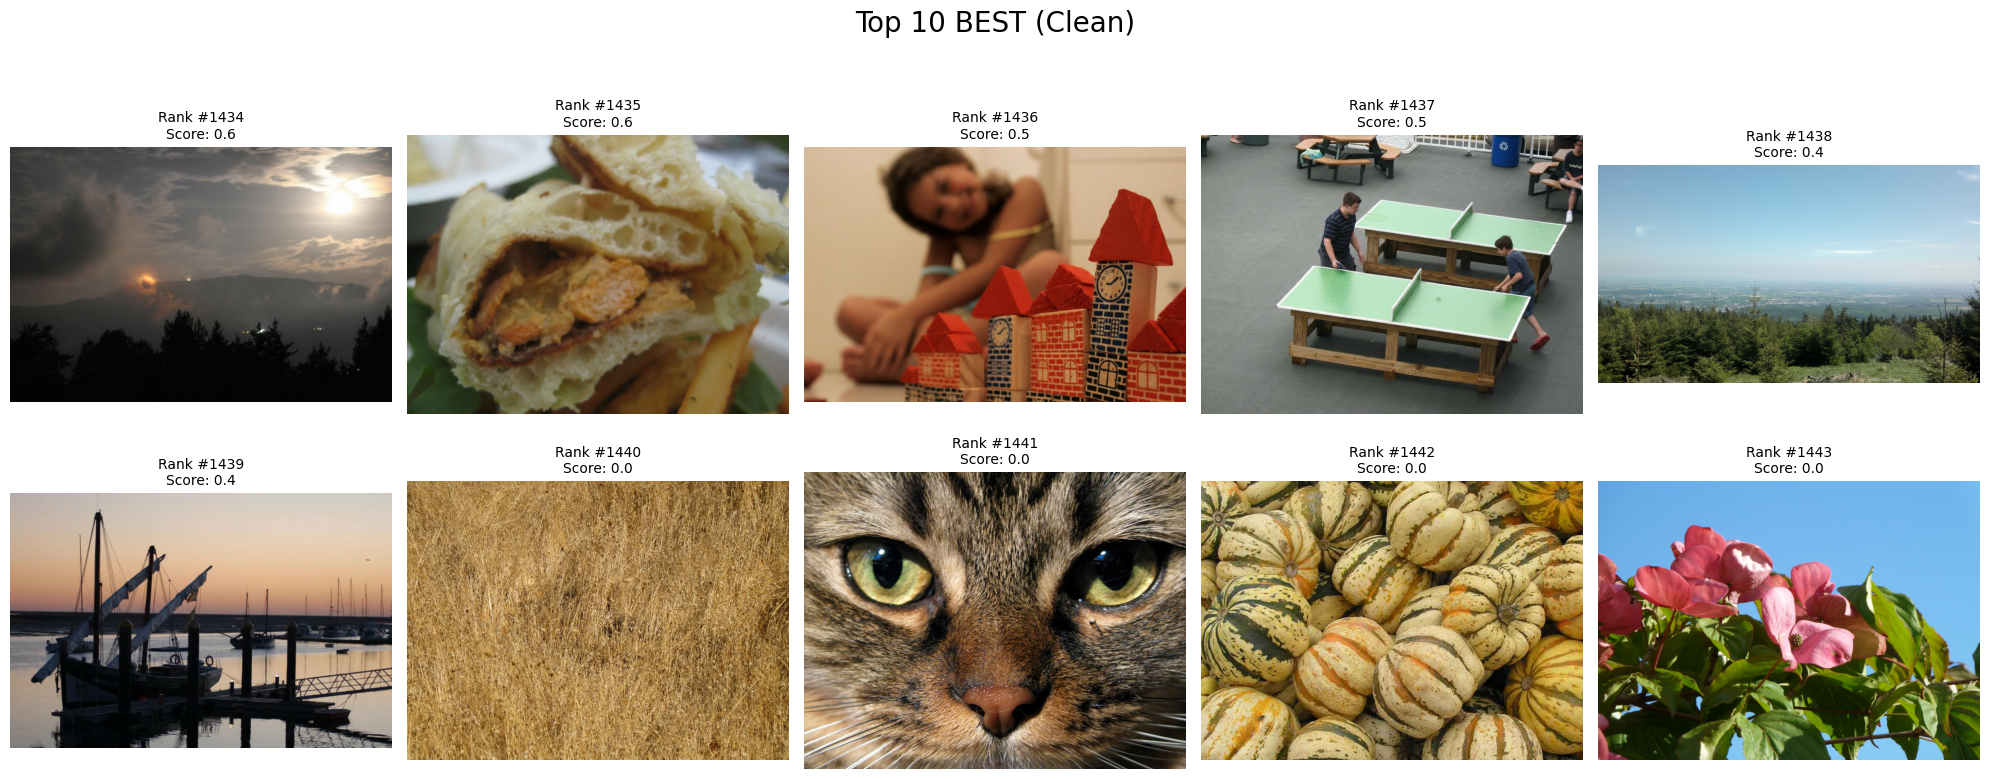

In [3]:
# --- Gallery View: Top 10 Worst vs Top 10 Best ---

def show_gallery(entries, title_prefix):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(f"{title_prefix}", fontsize=20, y=1.02)
    
    for i, ax in enumerate(axes.flat):
        if i >= len(entries): break
        entry = entries[i]
        item = full_dataset[entry["index"]]
        path = os.path.join(BASE_DIR, item["edit_image"][0] if isinstance(item["edit_image"], list) else item["edit_image"])
        
        if os.path.exists(path):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"Rank #{ranking_data.index(entry)}\nScore: {entry['final_score']:.1f}", fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print("Generating Top 10 WORST samples (Highest Ghosting/Cut Score)...")
show_gallery(ranking_data[:10], "Top 10 WORST (High Artifacts)")

print("Generating Top 10 BEST samples (Lowest Score)...")
show_gallery(ranking_data[-10:], "Top 10 BEST (Clean)")



In [4]:
# --- Threshold & Export ---
def preview_threshold(threshold):
    if not ranking_data: return
    kept = [x for x in ranking_data if x["final_score"] < threshold]
    percent_kept = (len(kept) / len(ranking_data)) * 100
    print(f"THRESHOLD: {threshold:.2f} | KEEPS {len(kept)} samples ({percent_kept:.1f}%) | DROPS {len(ranking_data)-len(kept)}")

if final_scores:
    interact(preview_threshold, threshold=FloatSlider(min=0, max=max(final_scores), step=0.1, value=np.percentile(final_scores, 90)));

print("\n--- TO EXPORT: ---")
print("CHOSEN_THRESHOLD = 15.0 # Set your value")
print("filtered = [full_dataset[x['index']] for x in ranking_data if x['final_score'] < CHOSEN_THRESHOLD]")
print("with open('dataset_qwen_pe_cleaned.json', 'w') as f: json.dump(filtered, f, indent=2)")



interactive(children=(FloatSlider(value=7.769443109625857, description='threshold', max=20.883743274746053), O…


--- TO EXPORT: ---
CHOSEN_THRESHOLD = 15.0 # Set your value
filtered = [full_dataset[x['index']] for x in ranking_data if x['final_score'] < CHOSEN_THRESHOLD]
with open('dataset_qwen_pe_cleaned.json', 'w') as f: json.dump(filtered, f, indent=2)
